# This notebook loads trajectories of an absorptive bistability and applies diffusion maps to learn about the manifold the trajectory spans.

In [38]:
Regime = "absorptive_bistable" ## used to load appropraite file

#  loading trajectory and using manifold my diffusion map script.

In [39]:
## load trajectory data from file
import pickle

## diffusion maps
from diffusion_maps import run_diffusion_map

## numerical
import numpy as np

## plotting libraries
import matplotlib.pyplot as plt
# %matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm


## plotly graphs
import plotly.plotly as py
import plotly.graph_objs as go

import random

import collections

In [40]:
## Style for plots

plt.style.use("ggplot")

## Functions for Plotting

In [41]:
def show_colorbar(x_index, name):
    ## show color scheme
    # http://matplotlib.org/examples/color/colormaps_reference.html

    gradient = np.linspace(0, 1, x_index)
    gradient = np.vstack((gradient, gradient))

    fig, axes = plt.subplots(figsize=(24,2))
    axes.set_title( ' colormaps', fontsize=14)
    axes.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))

    plt.axis("off")
    plt.show()

In [42]:
def colored_3d_plot(data,elev=45, azim=45):
    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data] for i in xrange(0,3)]

    x_index = len(np.asarray(to_plot_).T)/params['Ntraj']

    color_list = np.concatenate([np.linspace(0, 1, x_index)] * params['Ntraj'])
    colors = cm.jet(color_list)
    ax.scatter(*to_plot_,c=colors)
    ax.view_init(elev=elev, azim=azim)
    show_colorbar(x_index,'jet')

In [43]:
def plot_by_operator(data,traj1,elev=90,azim=45,dist = None,operator = "",filename = None):
    if isinstance(operator,collections.Iterable):
        num_expects = operator
    else:
        raise ValueError("operator type not implemented")
       
    ## sort data by expected photon number
    num_expects_indices = [(i,n) for i,n in enumerate(num_expects)]
    sorted_num_expects = sorted(num_expects_indices, key = lambda z: z[1])
    data_by_num = [data[i[0]] for i in sorted_num_expects]

    ## Figure 
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data_by_num] for i in xrange(0,3)]

    x_index = len(np.asarray(to_plot_).T)
    color_list = np.concatenate([np.linspace(0, 1, x_index)] )
    colors = cm.jet(color_list)
    ax.scatter(*np.asarray(to_plot_),c=colors)
    ax.view_init(elev=elev, azim=azim)
    if not dist is None:
        ax.dist = dist 
    if not filename is None:
        fig.savefig(filename,bbox_inches='tight')

    ## color bar    
#     show_colorbar(x_index,'jet')

In [44]:
## Usage:
# fig = make_plotly_3d_scatterplot(data,traj1,operator = traj_expects1[5])
# py.iplot(fig, filename='3d-scatter-colorscale')

def make_plotly_3d_scatterplot(data,traj1,operator = ""):
    if isinstance(operator,collections.Iterable):
        num_expects = operator
    else:
         raise ValueError("operator type not implemented")

    x,y,z = np.asarray(data).T
    i = num_expects
    
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            color=i,                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )

    data_plotly = [trace1]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data_plotly, layout=layout)
    return fig

# Diffusion maps

In [45]:
# ## using outputs from generate_diffussion_map_data()

# _, e_vecs = generate_diffussion_map_data(...)

def generate_diffussion_map_data(traj_data,
                                 traj_expects,
                                 diffusion_params = None,  ## some default parameters
                                 metric = None, ## None will default to "euclidean" metric
                                ):
    if metric is None:
        metric = "euclidean"
    if diffusion_params is None:
        diffusion_params = {
                    "gaussian_epsilon": 0.15,  ## width of Gaussian kernel.
                    "num_neighbors" : 100,  ## cutoff of number of neighbors, if using epsilon_cutoff
                    "alpha": 1.,  ## coefficient to use for diffusion maps. See the wikipedia article.
                    "eigen_dims" : 4, ## number of lower dimensions to consider, i.e. number of eigenvectors to find.
                   }

    traj1 = traj_data
    traj_expects1 = traj_expects

    diffusion_params["data_size"] = len(traj1) ## total number of points

    ######

    assert len(traj1) == len(traj_expects1)
    print "Number of points: " + str(len(traj1))

    if metric == "euclidean":
        e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                       diffusion_params,
                                       symmetric=True,
                                       neighbor_selection = "num_neighbors")
    elif metric == "FS_metric":
        e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                           diffusion_params,
                                           symmetric=True,
                                           metric = "FS_metric",
                                           neighbor_selection = "num_neighbors")
    else:
        raise ValueError("Unknown metric")
    return e_vals, e_vecs,
        

# Loading from other pkl file...

In [46]:
## load trajectory data from file

pkl_file = open('../SDEs/trajectory_data/QSD_'+ Regime +'.pkl', 'rb')
pkl_dict = pickle.load(pkl_file)
pkl_file.close()

In [47]:
## pre-process expectation values

traj_expects = np.concatenate(pkl_dict['expects']).real

In [48]:
pkl_dict['expects'].shape

(10, 5000, 9)

In [49]:
traj_expects.shape

(50000, 9)

In [50]:
pkl_dict['psis'].shape

(10, 5000, 100)

In [51]:
Ntraj,duration,Nfock = pkl_dict['psis'].shape

In [52]:
##  Extract data into points of format (psi.real,psi.imag) from all trajectories.

traj_data = np.concatenate(
            [[ np.concatenate([f(pkl_dict['psis'][traj_num][time_num]) 
                for f in (lambda x: x.real, lambda x: x.imag) ]) 
                    for traj_num in range(Ntraj)]
                        for time_num in range(int(duration))])

In [53]:
traj_data.shape

(50000, 200)

In [54]:
print 'Total number of points: ' + str(len(traj_data))

Total number of points: 50000


In [56]:
## sample 

sample_size = 5000

random.seed(1)

random_array = random.sample(range(Ntraj*duration),sample_size)
traj1 = np.asarray([traj_data[i] for i in random_array])
traj_expects1 = np.asarray([traj_expects[i] for i in random_array])

In [57]:
###

# EXPERIMENTS BELOW

In [58]:
###

# Experiment 1

Explore the parameters below

## Running Diffusion Map and Saving Result

In [59]:
# ## Lists over which to run the diffusion map algorithm

# points_per_sample = [1000,5000,10000]
# # points_per_sample = [500]  ## for testing purposes
# azim_range = range(0,360,360)
# epsilon_arr = np.linspace(0.05,0.5, 10)
# num_neighbors_range = [100]

# ## How much to down sample depends on the number of points we wish to use and the total trajectory length.
# total_len = len(traj_data)
# down_sample_arr = map(lambda points_to_use: int(total_len / points_to_use),points_per_sample)

In [60]:
# ## Running the algorithm for all parameters.

# def run_diffusion_maps_and_save_results():
#     # Generate experiment_dict_1. Takes a long time

#     experiment_dict_1 = {}

#     for down_sample in down_sample_arr:
#         for epsilon in epsilon_arr:
#             for num_neighbors in num_neighbors_range:
#                 for metric in (None,"FS_metric"):
#                     diffusion_params = {
#                                 "gaussian_epsilon": epsilon,  ## width of Gaussian kernel.
#                                 "num_neighbors" : num_neighbors,  ## cutoff of number of neighbors, if using epsilon_cutoff
#                                 "alpha": 1.,  ## coefficient to use for diffusion maps. See the wikipedia article.
#                                 "eigen_dims" : 6, ## number of lower dimensions to consider, i.e. number of eigenvectors to find.
#                                }
#                     experiment_dict_1[(down_sample,epsilon,num_neighbors,metric)] = generate_diffussion_map_data(
#                                                                             down_sample,diffusion_params,metric)

#     ## Save results from analysis

#     output = open( "./analysis_results_data/diffusion_map_absorptive_bistability_experiment1.pkl", 'wb')
#     pickle.dump(experiment_dict_1, output,protocol=0)
#     output.close()

In [61]:
### Run and save results  
### WARNING: THIS IS THE PART THAT TAKES A LONG TIME.

# run_diffusion_maps_and_save_results()

## load results from file

In [62]:
# pkl_file = open("./analysis_results_data/diffusion_map_absorptive_bistability_experiment1.pkl", 'rb')
# experiment_dict_1 = pickle.load(pkl_file)
# pkl_file.close()

## Plot results

In [63]:
# def plot_experiment_result(down_sample, epsilon, num_neighbors, metric, obs_num = 4,dist = 5.,filename=None):
#     ## load data from experiment_dict_1

#     down_sample,epsilon,num_neighbors,metric = down_sample, epsilon, num_neighbors, metric
#     _,e_vecs = experiment_dict_1[(down_sample,epsilon,num_neighbors,metric)]

#     ## Getting the right trajectory from data

#     traj1 = traj_data[0::down_sample]
#     traj_expects1 = traj_expects[:,::down_sample]

#     ## Plotting outputs

#     data = e_vecs.T[1:4].T
    
# #     for azim in azim_range:
# #         plot_by_operator(data,traj1,operator=traj_expects1[obs_num],azim=azim,filename)

#     plot_by_operator(data,traj1,operator=traj_expects1[obs_num],azim=0.,dist = dist,filename=filename)

In [64]:
## Euclidean 

# for epsilon_el in epsilon_arr:
#     filename = './Figures/euclidean_absorptive_bistable_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[0], epsilon_el,num_neighbors_range[-1],None,filename=filename)

In [65]:
# plot_experiment_result(down_sample_arr[1], epsilon_arr[0],num_neighbors_range[-1],"FS_metric",dist = 5.)

In [66]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",dist = 5.,filename=filename)

In [67]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_Jz_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=2,filename=filename)

In [68]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_Jm_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=1,filename=filename)

In [69]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_aJp_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=5,filename=filename)

In [70]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_a_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=0,filename=filename)

In [71]:
# for epsilon_el in epsilon_arr:
#     filename = './Figures/FS_metric_absorptive_bistable_aa_' + '%.5f' % (epsilon_el) + ".pdf"
#     plot_experiment_result(down_sample_arr[-1], epsilon_el,num_neighbors_range[-1],"FS_metric",obs_num=3,filename=filename)

# Experiment 2

Vary epsilon over a wider range than in experiment 1.

In [72]:
traj_data.shape

(50000, 200)

In [73]:
traj_expects.shape

(50000, 9)

In [74]:
def make_data_eps(epsilon = 0.5):

    num_neighbors = 100
    metric = "FS_metric"

    diffusion_params = {
            "gaussian_epsilon": epsilon,  ## width of Gaussian kernel.
            "num_neighbors" : num_neighbors,  ## cutoff of number of neighbors, if using epsilon_cutoff
            "alpha": 1.,  ## coefficient to use for diffusion maps. See the wikipedia article.
            "eigen_dims" : 6, ## number of lower dimensions to consider, i.e. number of eigenvectors to find.
           }
    _,e_vecs = generate_diffussion_map_data(traj1,traj_expects1,diffusion_params,metric)

    data = e_vecs.T[1:4].T
    
    return data

In [76]:
epsilon_list = [0.1,0.5,0.7,1.0]

In [77]:
data_dict = {}

In [78]:
for eps in epsilon_list:
    data_dict[eps] = make_data_eps(epsilon = eps)
    
data_dict['traj1'] = traj1
data_dict['operator_expects'] = traj_expects1

data_dict

Number of points: 5000
using num_neighbors  
Number of points: 5000
using num_neighbors  
Number of points: 5000
using num_neighbors  
Number of points: 5000
using num_neighbors  


{0.1: array([[ 0.2284879 ,  0.01379575, -0.01329137],
        [ 0.00240239,  0.01692523,  0.02539104],
        [ 0.22815417,  0.01177002, -0.01518642],
        ..., 
        [ 0.00119455,  0.016767  ,  0.02261822],
        [ 0.00234253,  0.01721686,  0.01990877],
        [ 0.23127245,  0.01508786,  0.00459314]]),
 0.5: array([[-0.09152304,  0.03644338,  0.23447845],
        [ 0.12240878,  0.09580818,  0.048196  ],
        [-0.09244219,  0.03585207,  0.24760491],
        ..., 
        [ 0.10116447,  0.02537085,  0.01515184],
        [ 0.09357131,  0.13181821,  0.02160222],
        [-0.12857549, -0.06864292,  0.15860832]]),
 0.7: array([[ 0.04821349, -0.14302281, -0.21233934],
        [-0.07444352, -0.12219672, -0.07801702],
        [ 0.06546501, -0.14920886, -0.20341423],
        ..., 
        [-0.07077924, -0.07288442, -0.09925707],
        [-0.12364063, -0.09469694,  0.04434071],
        [ 0.06795314, -0.09860133, -0.13962771]]),
 1.0: array([[ 0.0343726 , -0.0192554 , -0.06521832],
 

## Save Experiment 2

In [79]:
output = open( "./analysis_results_data/diffusion_map_absorptive_bistability_QSD_experiment2.pkl", 'wb')
pickle.dump(data_dict, output,protocol=0)
output.close()

## Load experiment 2

In [80]:
pkl_file = open( "./analysis_results_data/diffusion_map_absorptive_bistability_QSD_experiment2.pkl", 'rb')
data_dict = pickle.load(pkl_file)
pkl_file.close()

In [88]:
## View figures interactively

%matplotlib auto
plot_by_operator(data_dict[0.7],traj1,elev=-70,azim=50,dist = 5,operator = traj_expects1.T[1],filename = None)

Using matplotlib backend: MacOSX


In [90]:
%matplotlib inline

In [91]:
traj_expects1.T

array([[-4.88845894, -0.30639545, -5.26511789, ..., -5.47868616,
        -4.00437602, -0.25087787],
       [-0.47935488, -0.36133123, -0.14353524, ..., -0.17750039,
        -0.46237483, -0.42980819],
       [-0.11656568, -0.34042558, -0.429761  , ..., -0.31042094,
         0.07232351, -0.18952509],
       ..., 
       [-0.47935488, -0.36133123, -0.14353524, ..., -0.17750039,
        -0.46237483, -0.42980819],
       [-0.47935488, -0.36133123, -0.14353524, ..., -0.17750039,
        -0.46237483, -0.42980819],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

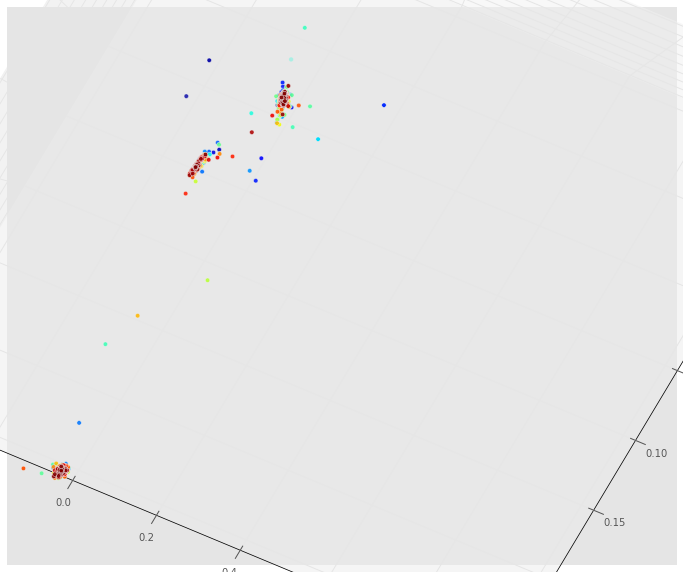

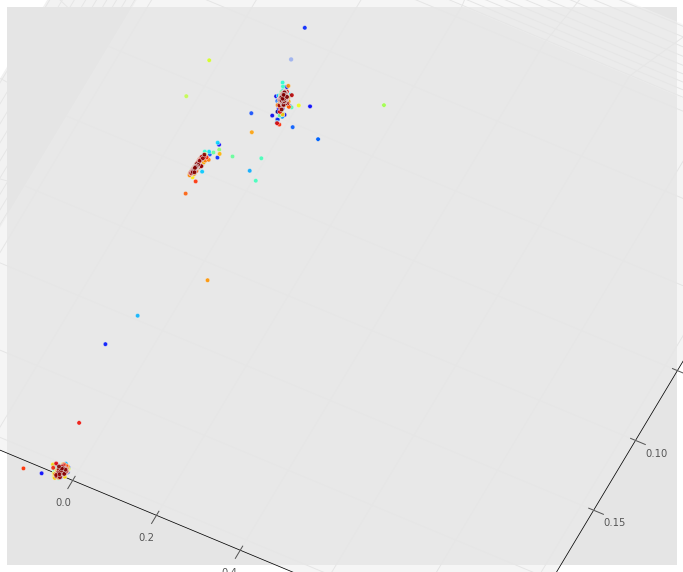

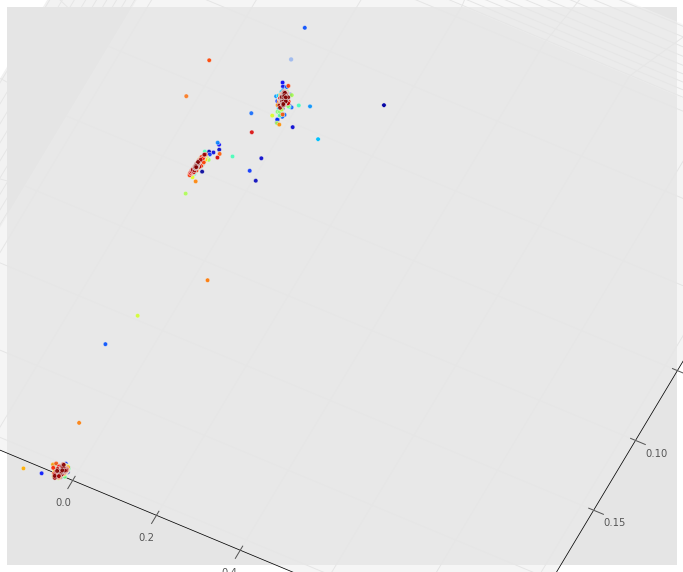

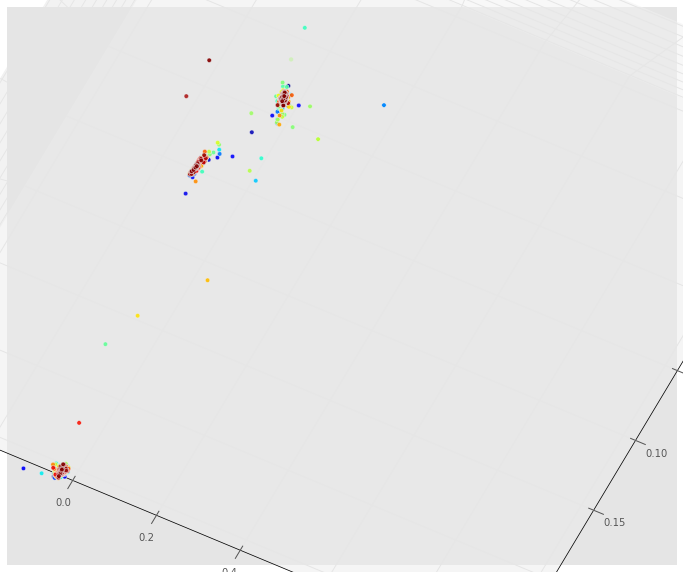

In [92]:
for obs in range(6):
    plot_by_operator(data_dict[0.1],traj1,elev=90,azim=30,dist = 5,operator = traj_expects1.T[obs],filename = "./Figures/FS_absorptive_bistability_QSD_eps0.1_obs"+str(obs)+".pdf")

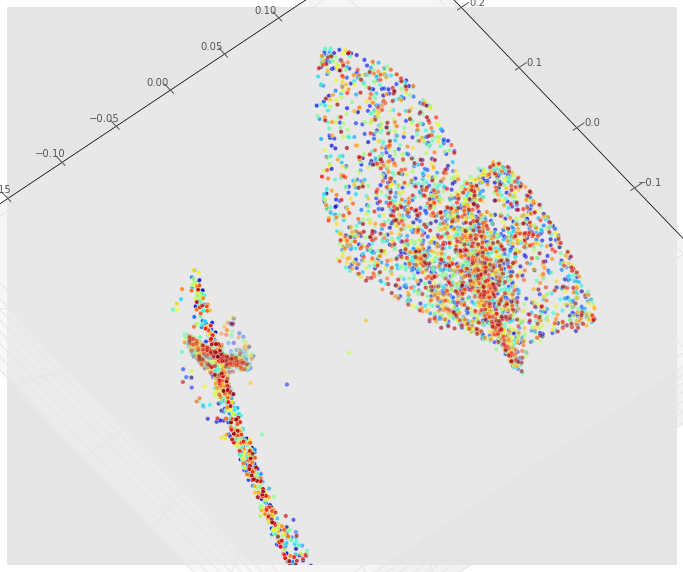

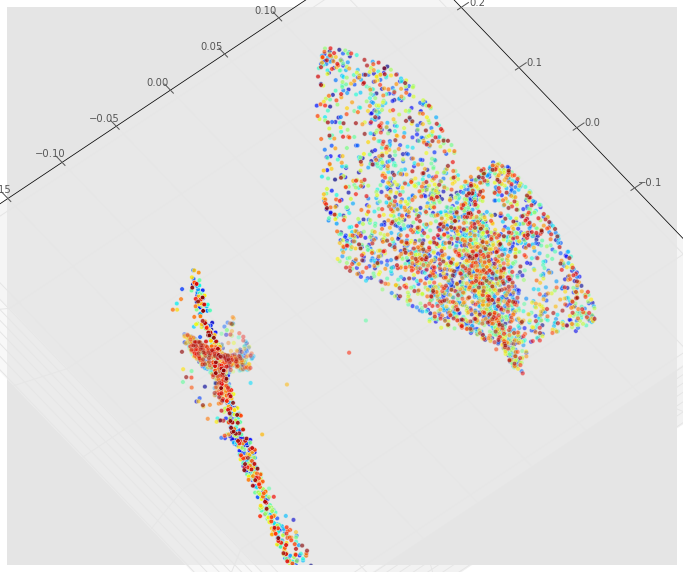

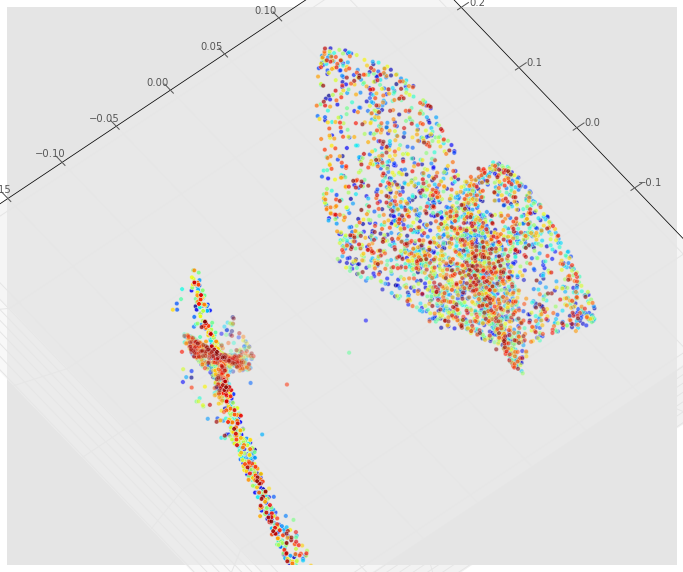

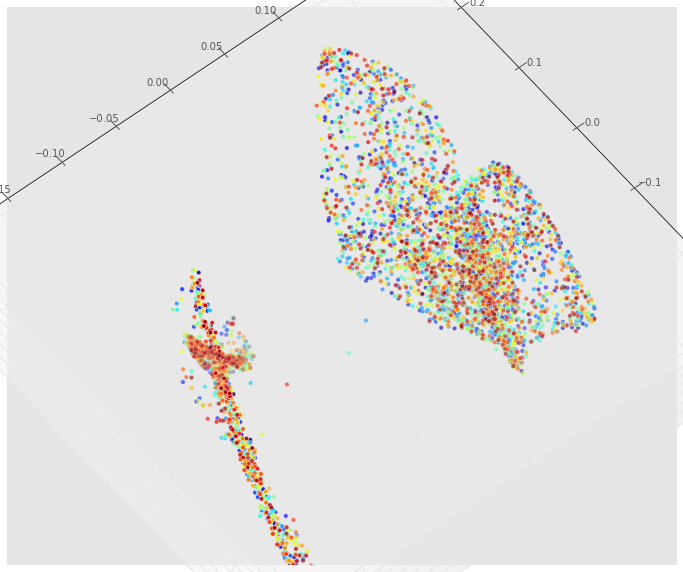

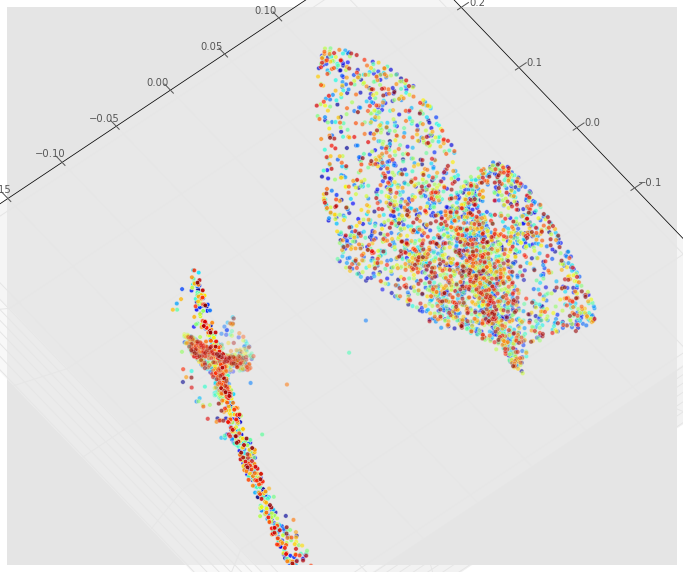

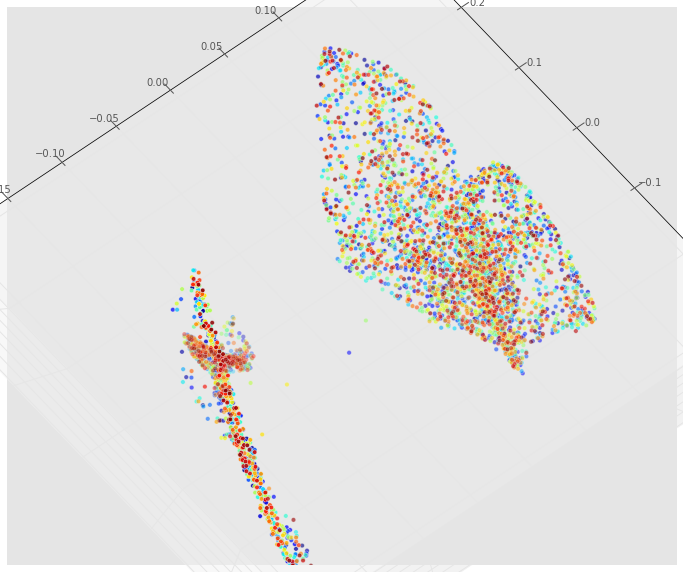

In [84]:
for obs in range(6):
    plot_by_operator(data_dict[0.5],traj1,elev=90,azim=230,dist = 6,operator = traj_expects1.T[obs],filename = "./Figures/FS_absorptive_bistability_QSD_eps0.5_obs"+str(obs)+".pdf")

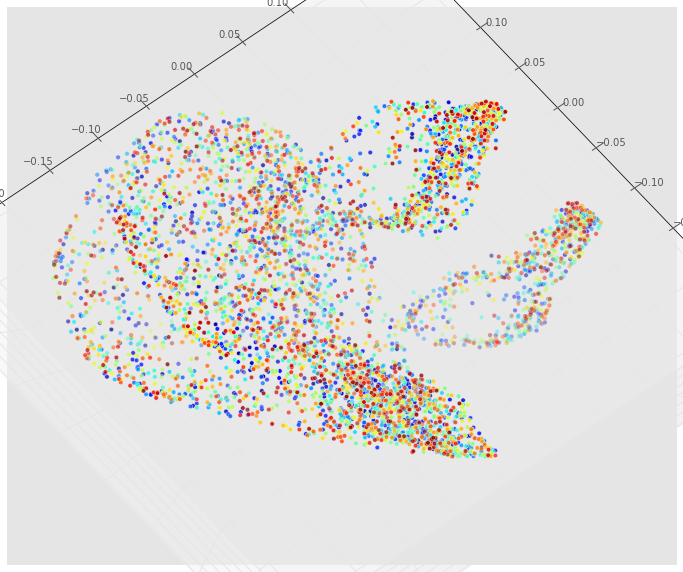

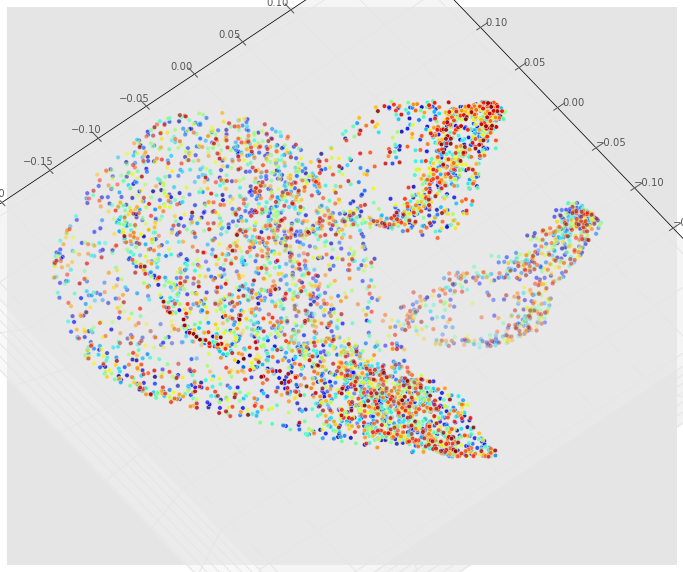

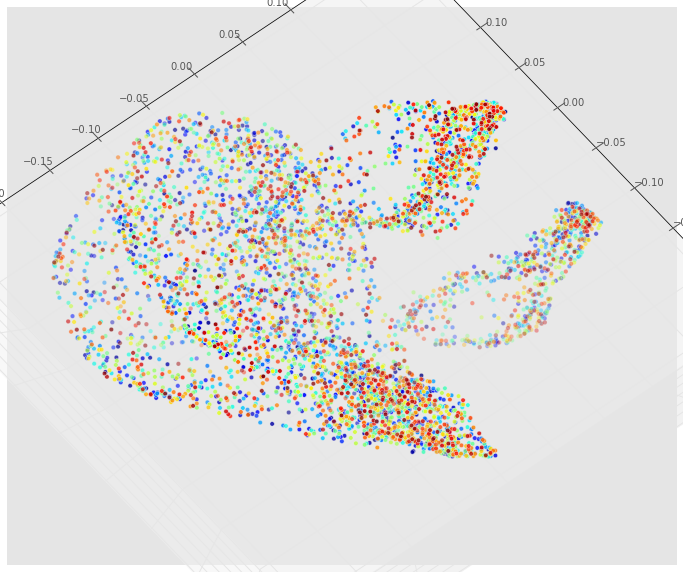

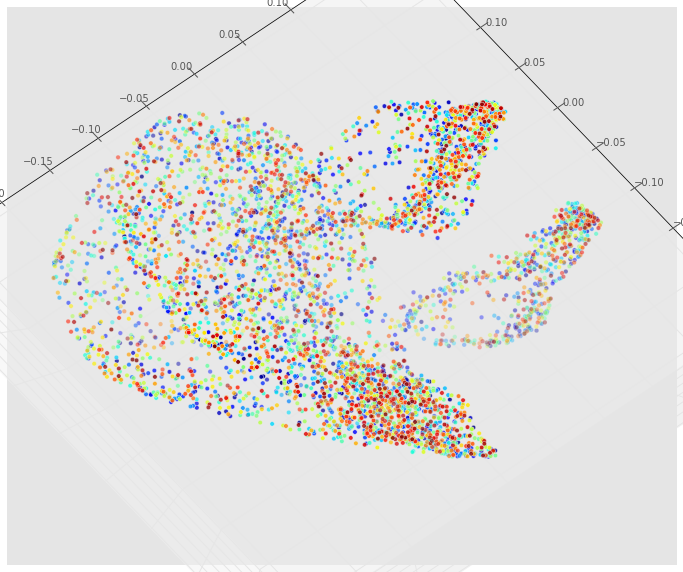

In [86]:
for obs in range(6):
    plot_by_operator(data_dict[0.7],traj1,elev=90,azim=230,dist = 6,operator = traj_expects1.T[obs],filename = "./Figures/FS_absorptive_bistability_QSD_eps0.5_obs"+str(obs)+".pdf")

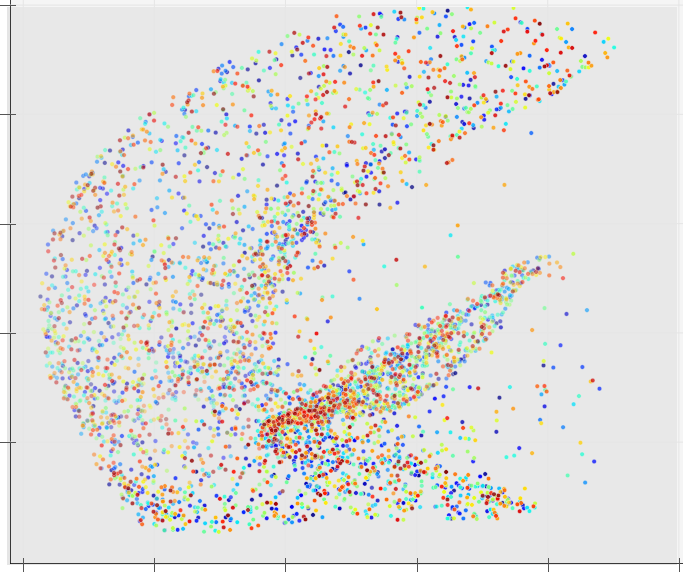

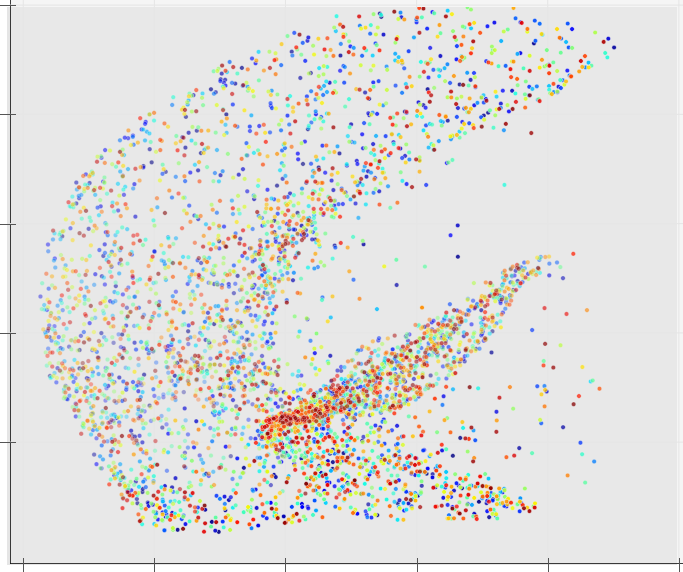

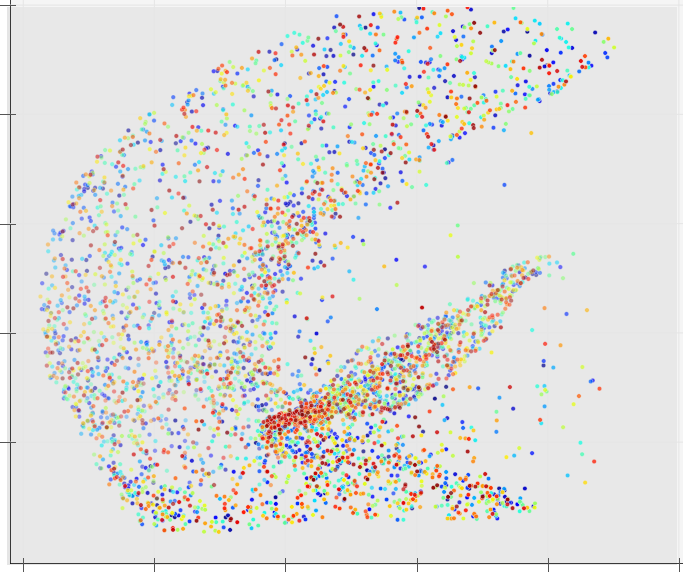

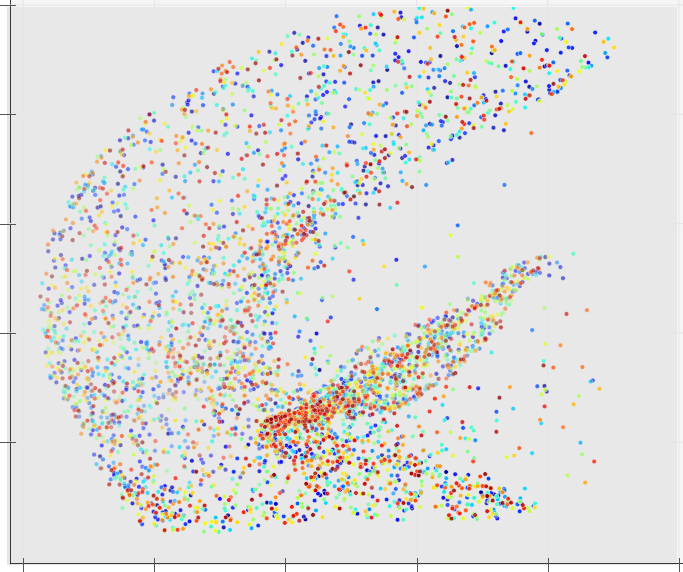

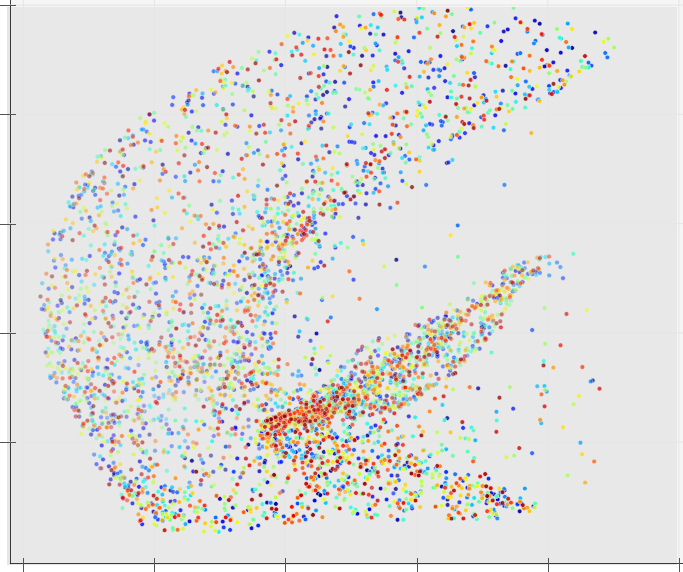

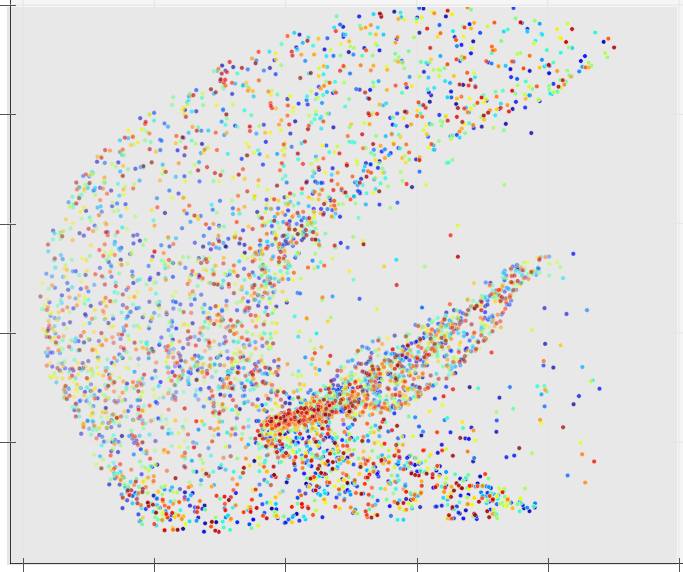

In [85]:
for obs in range(6):
    plot_by_operator(data_dict[1.0],traj1,elev=90,azim=90,dist = 5,operator = traj_expects1.T[obs],filename = "./Figures/FS_absorptive_bistability_QSD_eps1.0_obs"+str(obs)+".pdf")